In [1]:
import numpy as np
import pandas as pd
import scipy.sparse as ss
import statsmodels.stats.weightstats as smw
from tqdm import tqdm,trange

import sys
sys.path.append('../d03_src/')
import vars
from utils import RMSE
from scipy.stats import pearsonr
import process_infutor as pri
import process_census as prc
import evaluation as eval
import visualization as viz

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Helvetica Light'
plt.rc('axes', unicode_minus=False)
plots_dir = '../plots/'

# Validations

In this notebook we validate:
- How well our estimates (and Infutor) perform against ACS population counts
- How well our estimates (and Infutor) perform against ACS population flows
- Whether our estimates (and Infutor) contain demographic biases

In the paper, the first two points are the topic of Figure 2. The third is the topic of Figure 3. These figures will be produced in this notebook.

## 1. Collecting the Data

Collect membership matrices and indices:

In [2]:
_geographies = ['blockgroup', 'tract', 'county', 'state']
C_dict = {}
for fine_idx, fine_geography in enumerate(_geographies):
    for coarse_geography in _geographies[1+fine_idx:]:
        C_dict[(fine_geography, coarse_geography)] = prc.get_geography_matrices(fine_geography,
                                                                                coarse_geography,
                                                                                ignore_PR=True)

Collect the estimates:

In [3]:
M_dict = {year: ss.load_npz(f"{vars.MIGRATE_dir}{year}_{vars.MIGRATE_str}.npz") for year in trange(2011, 2020)}
for y, M in M_dict.items(): assert not (M < 0).nnz, f'Negative entries in {y} matrix'

100%|█████████████████████████████████████████████| 9/9 [00:24<00:00,  2.73s/it]


Collect INFUTOR:

In [4]:
E_dict = {year:pri.load_INFUTOR_matrix(year, ignore_PR=True) for year in trange(2011,2020)}

100%|█████████████████████████████████████████████| 9/9 [01:07<00:00,  7.46s/it]


Collect the pre-IPF Infutor:

In [5]:
S_dict = {year: ss.load_npz(f"{vars._infutor_dir_processed}CRD4/OD_pairs/ADDRID/S_matrices/{year}_blockgroup_{vars.MIGRATE_str[2:]}.npz") for year in trange(2011,2020)}

100%|█████████████████████████████████████████████| 9/9 [00:34<00:00,  3.80s/it]


Collect county-to-county and state-to-state flows (indexed by final year):

In [6]:
F_dict, Fhat_dict = {'state':{}, 'county':{}}, {'state':{}, 'county':{}}
for year in range(2011,2020):
    F_dict['state' ][year], Fhat_dict['state' ][year] = prc.get_ACS1_state_to_state(  year, ignore_PR=True)
    F_dict['county'][year], Fhat_dict['county'][year] = prc.get_ACS5_county_to_county(year, ignore_PR=True)

F_dict_scaled = {geography:{y: ((M_dict[y]).sum()/F.sum())*F for y,F in flows.items()} for geography,flows in F_dict.items()}

Collect population counts at the CBG and TRACT level (use ACS 5-years indexed by the final year)

In [7]:
ACS_CBG   = prc.get_demographics(features=('Total', 'Population'), geography='BLOCKGROUP', ignore_PR=True, years=[y for y in range(2010,2020)])
ACS_TRACT = prc.get_demographics(features=('Total', 'Population'), geography='TRACT',      ignore_PR=True, years=[y for y in range(2010,2020)])
CENSUS_CBG = prc.get_census2010_CBG_demographics('Population', ignore_PR=True)

Collect the PEP-county population (that's our $P_0$), and aggregate to state:

In [8]:
county_idx = prc.get_geography_indices('county', ignore_PR=True)
PEP_df = pd.read_csv(f'{vars._census_demographics_dir}processed/COUNTY_PEP.csv', index_col='GEOID')
PEP_df_ordered = PEP_df.loc[pd.Series(county_idx).sort_values().index]

PEP_COUNTY = {year: PEP_df_ordered[f'POPESTIMATE{year}'].values for year in range(2010,2020)}
PEP_STATE  = {year: C_dict[('county', 'state')].T @ county_pop  for year,county_pop in PEP_COUNTY.items()}

Collect the PEP-county net domestic migration:

In [9]:
PEP_migration_net = {y: PEP_df_ordered[f'DOMESTICMIG{y}'].values for y in range(2011,2020)}
ACS_migration_net = {year: np.array(F.sum(axis=0)).flatten() - np.array(F.sum(axis=1)).flatten() for year,F in F_dict['county'].items()}

Collect the ACS in-migration rates:

In [10]:
ACS_inmigration = {'state': {year: prc.get_ACS1_state_inmigration(year,  ignore_PR=True, rate=False) for year in trange(2011,2020)},
                   'county':{year: prc.get_ACS5_county_inmigration(year, ignore_PR=True, rate=False) for year in trange(2011,2020)}}

ACS_inmigration_rate = {'state': {year: prc.get_ACS1_state_inmigration(year,  ignore_PR=True) for year in trange(2011,2020)},
                        'county':{year: prc.get_ACS5_county_inmigration(year, ignore_PR=True) for year in trange(2011,2020)}}

100%|█████████████████████████████████████████████| 9/9 [00:41<00:00,  4.59s/it]


Let's put all the populations and flows together, making sure to note whether estimates are 1 or 5 years:

In [11]:
#Clean the five years data:
eval_ACS_CBG = {y:v for y,v in ACS_CBG.items() if y in range(2014,2019)} #shift one year back as we are using rows
eval_ACS_TRACT = {y:v for y,v in ACS_TRACT.items() if y in range(2014,2019)} #shift one year back as we are using rows
eval_ACS_COUNTY_to_COUNTY = {y:v for y,v in F_dict['county'].items() if y in range(2015,2020)}
eval_ACS_COUNTY_to_COUNTY_scaled = {y:v for y,v in F_dict_scaled['county'].items() if y in range(2015,2020)}
eval_ACS_COUNTY_inmigration = {y: df['Estimate'].values for y,df in ACS_inmigration['county'].items() if y in range(2015,2020)}
eval_ACS_COUNTY_inmigration_rate = {y: df['Estimate'].values for y,df in ACS_inmigration_rate['county'].items() if y in range(2015,2020)}

data_for_validation = {'population':{('ACS', 'blockgroup'): (eval_ACS_CBG, 5),
                                     ('ACS', 'tract'): (eval_ACS_TRACT, 5),
                                     ('PEP', 'county'): (PEP_COUNTY, 1),
                                     ('PEP', 'state'): (PEP_STATE, 1)},
                       'flows':{('ACS', 'county'): (eval_ACS_COUNTY_to_COUNTY, 5),
                                ('ACS', 'state'): (F_dict['state'], 1)},
                       'in-migration':{('ACS', 'county'):(eval_ACS_COUNTY_inmigration, 5),
                                       ('ACS', 'state') :({y: df['Estimate'].values for y,df in ACS_inmigration['state'].items()}, 1)},
                       'in-migration_rate':{('ACS', 'county'):(eval_ACS_COUNTY_inmigration_rate, 5),
                                            ('ACS', 'state') :({y: df['Estimate'].values for y,df in ACS_inmigration_rate['state'].items()}, 1)}}

## 2. Performance Validation (Figure 2)

We will validate estimates on matrices indexed by 2011-2019 (final year), and we will report values for MIGRATE and Infutor (after scaling appropriately):

In [12]:
estimates_range = range(2011,2020)
estimates = {'Infutor': {y: ((M_dict[y]).sum()/E.sum())*E for y,E in E_dict.items()},
             'MIGRATE':M_dict}
metrics = {'RMSE':RMSE, 'Pearson corr.': lambda x, y, w=None: pearsonr(x, y)[0] if w is None else smw.DescrStatsW(np.column_stack((x, y)), weights=w).corrcoef[0,1]}

all_validations_df = {}

We will rely on the following function:

In [13]:
eval.validation?

Signature:
eval.validation(
    quantity,
    estimates,
    metrics,
    data_for_validation,
    C_matrices,
    ground_truth_ready=False,
    rate=False,
    rate_col=False,
    full_data_range=range(2010, 2020),
    estimates_range=range(2011, 2020),
    weight_by_population=False,
    weight_col=False,
)
Docstring:
Computes the validation for a specific quantity (population, all flows,
    migration rates) and estimates.

Parameters
----------
quantity : `population`, `flows`, `flows-stayers`, `flows-outmigration`, `flows-inmigration`
    what summary of the estimates to validate
    
estimates : dict
    dictionary with {dataset:{year:matrix}} structure
    
metrics : dict
    dictionary with {metric:function}, where function takes two arguments
    
data_for_validation : dict
    dictionary with {(data_source, data_geography):(values, data_period)}
    
C_matrices : dict
    dictionary with membership matrices
    
Returns
----------
pd.DataFrame
    multiIndex DataFram whose in

Do a run through all sources:

In [14]:
for quantity in tqdm(['population', 'flows', 'movers', 'stayers', 'in-migration', 'in-migration_rate']):
    df = eval.validation(quantity if 'rate' not in quantity else quantity.strip('_rate'),
                         estimates=estimates,
                         metrics=metrics,
                         weight_by_population='rate' in quantity, weight_col=True,
                         data_for_validation=data_for_validation.get(quantity, data_for_validation['flows']),
                         C_matrices=C_dict,
                         ground_truth_ready=quantity in ['population', 'flows', 'in-migration', 'in-migration_rate'],
                         rate='rate' in quantity, rate_col='in-migration' in quantity,
                         full_data_range=range(2010,2020) if quantity=='population' else range(2011,2020),
                         estimates_range=estimates_range)
    #Include RMSE reduction:
    for source in df['RMSE'].columns.levels[0]:
        #print(df)
        df[('RMSE',source,'Reduction (%)')] = 100*(1-df[('RMSE', source, 'MIGRATE')]/df[('RMSE', source, 'Infutor')])
        sorted_df = df.sort_index(axis=1,level=[0,1,2],ascending=[False, True, True])
    #Log:
    all_validations_df[quantity] = sorted_df

100%|████████████████████████████████████████████| 6/6 [22:34<00:00, 225.77s/it]


### Bar chart of RMSE reductions

In [15]:
geographies_cmap = 'YlOrRd'
flows_cmap = 'PuBuGn'
use_mean = True

Define parameters:

In [16]:
plot_params = {'population':{'labels':['Block Group', 'Tract', 'County', 'State'],
                             'cmap':plt.get_cmap(geographies_cmap),
                             'title':'Population counts',
                             'invert':True},
               'flows':{'labels':['State', 'County'], 'cmap':plt.get_cmap(flows_cmap),
                        'title':'Population flows', 'invert':False},
               'stayers':{'labels':['State', 'County'], 'cmap':plt.get_cmap(flows_cmap),
                        'title':'Population flows (area stayers only)', 'invert':False},
               'movers':{'labels':['State', 'County'], 'cmap':plt.get_cmap(flows_cmap),
                        'title':'Population flows (area movers only)', 'invert':False, 'unit':1_000},
               'in-migration':{'labels':['State', 'County'], 'cmap':plt.get_cmap(flows_cmap),
                        'title':'In-migration', 'invert':False, 'unit':1_000},
               'in-migration_rate':{'labels':['State', 'County'], 'cmap':plt.get_cmap(flows_cmap),
                        'title':'In-migration rate (per 1,000)', 'invert':False, 'size_scaler':2_000}}

max_values = {('population', 'Block Group'):80,
              ('population', 'Tract'):80,
              ('population', 'County'):10,
              ('population', 'State'):50,
              ('flows', 'State'):50,
              ('flows', 'County'):10,
              ('stayers', 'State'):50,
              ('stayers', 'County'):10,
              ('movers', 'State'):60,
              ('movers', 'County'):20,
              ('in-migration_rate', 'County'):200,
              ('in-migration_rate', 'State'):100,
              ('in-migration', 'County'):250,
              ('in-migration', 'State'):750}

Let's build the paper figures:

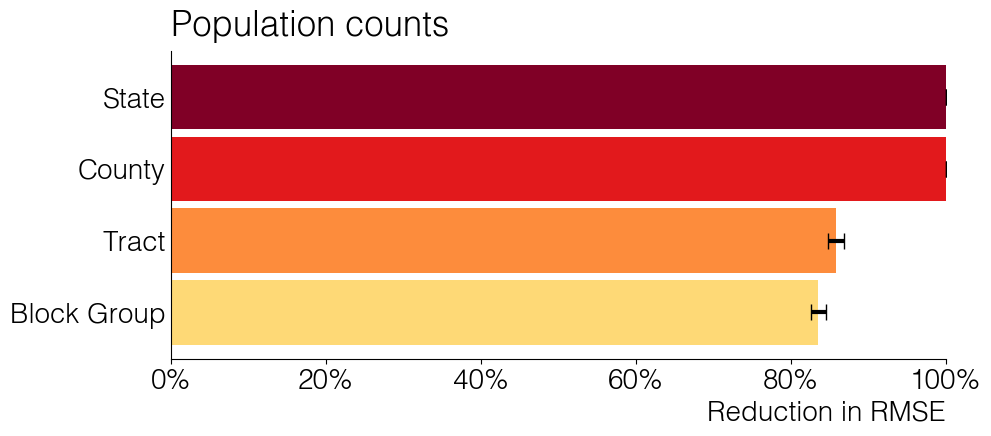

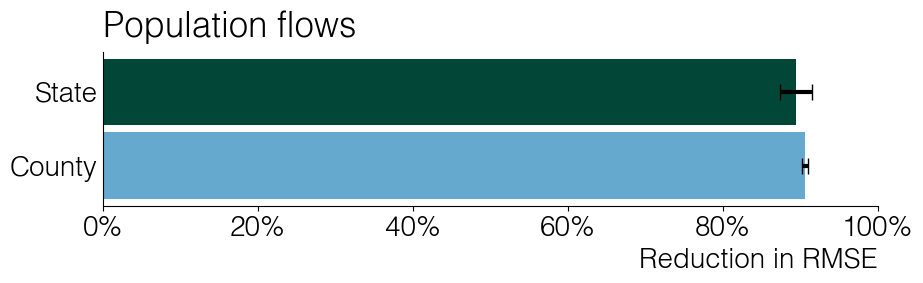

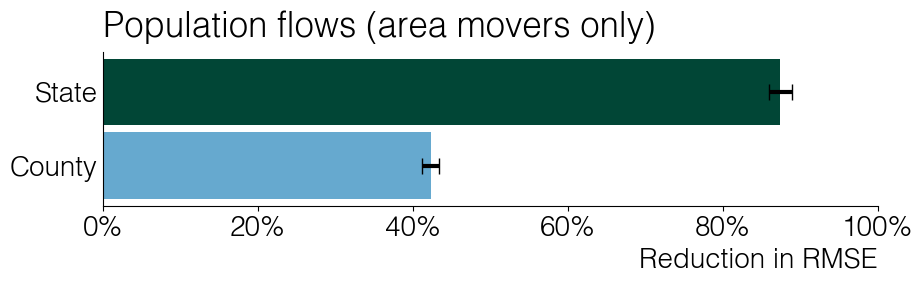

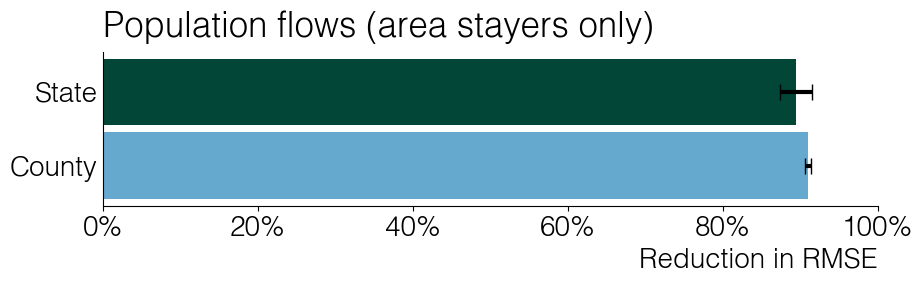

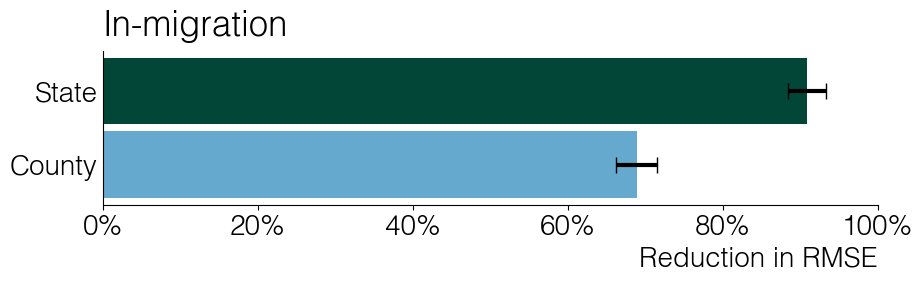

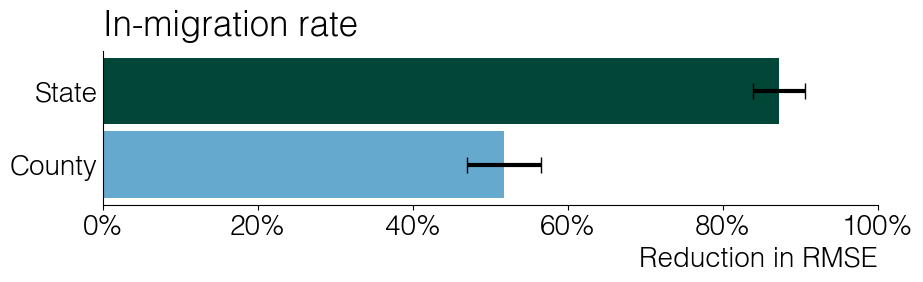

In [17]:
for quantity in ['population', 'flows', 'movers', 'stayers', 'in-migration', 'in-migration_rate']:
    #Collect the dataframe and estimates:
    df = all_validations_df[quantity]
    est, CIs = eval.get_RMSE_reductions(df)
    #Create plot:
    n_validations = len(df.columns.get_level_values(1).unique())
    fig, ax = plt.subplots(figsize=(10, n_validations))
    #Plot:
    ax = viz.plot_RMSE_reduction(est[::-1 if plot_params[quantity]['invert'] else 1],
                                 CIs=CIs.values[::-1 if plot_params[quantity]['invert'] else 1],
                                 labels=plot_params[quantity]['labels'][::-1 if plot_params[quantity]['invert'] else 1],
                                 colors=[plot_params[quantity]['cmap']((len(est)-i)/len(est)) for i in range(len(est))],
                                 ax=ax,
                                 title=plot_params[quantity].get('title',False) if 'rate' not in quantity else 'In-migration rate',
                                 y_label=True, legend=False)
    plt.savefig(f'{plots_dir}validations-RMSE-{quantity}.png', dpi=300, bbox_inches='tight')
    plt.savefig(f'{plots_dir}validations-RMSE-{quantity}.pdf', dpi=300, bbox_inches='tight')
    plt.show()

Print summaries with numbers for text:

In [18]:
for quantity in ['population', 'flows', 'movers', 'stayers', 'in-migration', 'in-migration_rate']:
    #Collect the dataframe and estimates:
    df = all_validations_df[quantity]
    est, CIs = eval.get_RMSE_reductions(df)
    print('\n')
    print(quantity)
    display(est)
    display(CIs)



population


ACS 5-year blockgroup population     83.595362
ACS 5-year tract population          85.882799
PEP 1-year county population        100.000000
PEP 1-year state population         100.000000
dtype: float64

ACS 5-year blockgroup population    9.673890e-01
ACS 5-year tract population         1.002117e+00
PEP 1-year county population        6.599255e-13
PEP 1-year state population         2.402517e-12
dtype: float64



flows


ACS 1-year state flows     89.462553
ACS 5-year county flows    90.648699
dtype: float64

ACS 1-year state flows     2.118498
ACS 5-year county flows    0.389371
dtype: float64



movers


ACS 1-year state movers     87.462468
ACS 5-year county movers    42.344289
dtype: float64

ACS 1-year state movers     1.534514
ACS 5-year county movers    1.098343
dtype: float64



stayers


ACS 1-year state stayers     89.463168
ACS 5-year county stayers    91.012807
dtype: float64

ACS 1-year state stayers     2.120042
ACS 5-year county stayers    0.439072
dtype: float64



in-migration


ACS 1-year state in-migration     90.925800
ACS 5-year county in-migration    68.923675
dtype: float64

ACS 1-year state in-migration     2.471259
ACS 5-year county in-migration    2.645308
dtype: float64



in-migration_rate


ACS 1-year state in-migration     87.304565
ACS 5-year county in-migration    51.749742
dtype: float64

ACS 1-year state in-migration     3.335849
ACS 5-year county in-migration    4.793884
dtype: float64

### Scatterplots with correlations

First we flatten the data (and save):

In [19]:
all_validations_array = {}
for quantity in tqdm(['population', 'flows', 'movers', 'stayers', 'in-migration', 'in-migration_rate']): 

    #Get the ground truth:
    all_validations_array[quantity] = {}
    validation_dict = data_for_validation.get(quantity, data_for_validation['flows'])

    #Iterate over data sources:
    for (source, geography), (data_dict, data_period) in validation_dict.items():
        estimates, data, years, w = eval.get_flattened_data(quantity if 'rate' not in quantity else quantity.strip('_rate'),
                                                            estimates_yearly_dict=M_dict,
                                                            ground_truth_yearly_dict=data_dict,
                                                            ground_truth_span_in_years=data_period,
                                                            aggregation_matrix=None if geography == 'blockgroup' else C_dict[('blockgroup', geography)],
                                                            ground_truth_ready=quantity in ['population', 'in-migration', 'in-migration_rate'],
                                                            weight_by_population='rate' in quantity,
                                                            weight_col=True,
                                                            rate='rate' in quantity,
                                                            rate_col=quantity=='in-migration')
        df = pd.DataFrame({'Estimate':estimates, 'Data':data, 'Year':years, 'Weight':w})
        #Log:
        _geography = 'Block Group' if geography == 'blockgroup' else geography.capitalize()
        all_validations_array[quantity][(source, _geography)] = df

100%|█████████████████████████████████████████████| 6/6 [04:27<00:00, 44.60s/it]


The correlation plots:

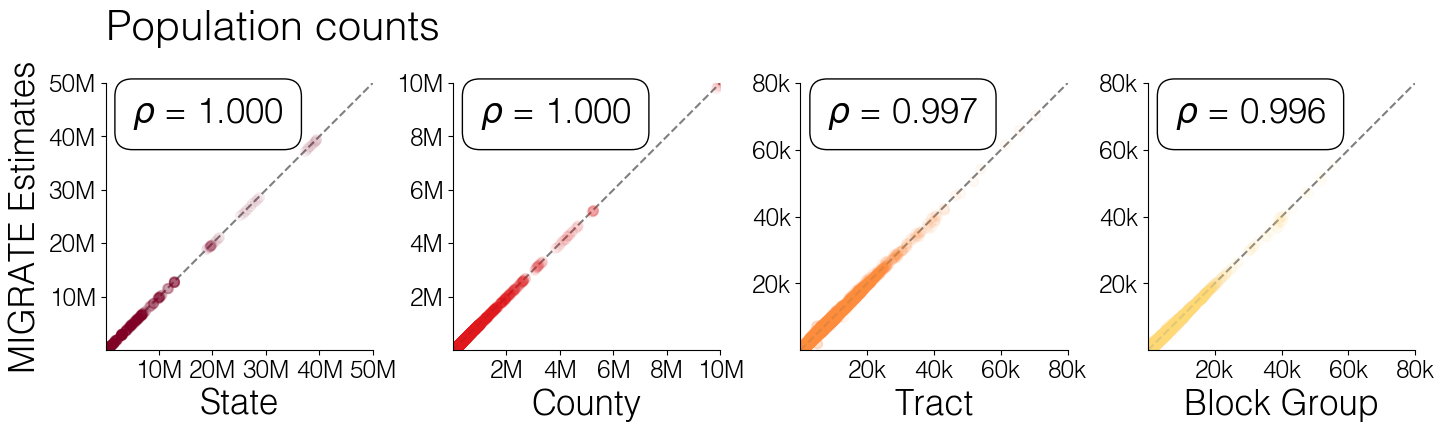

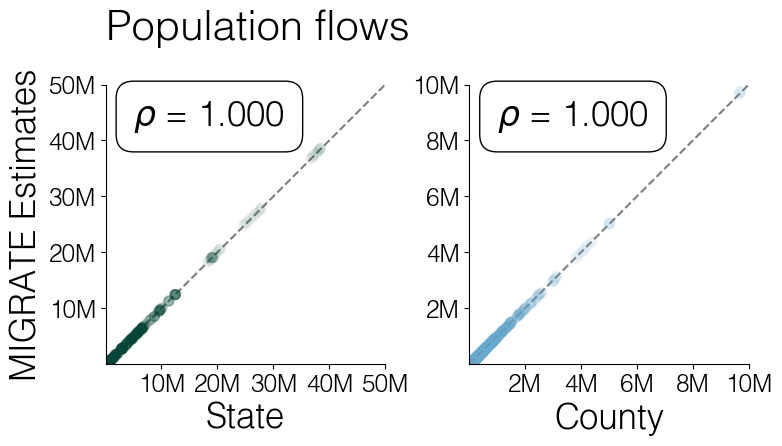

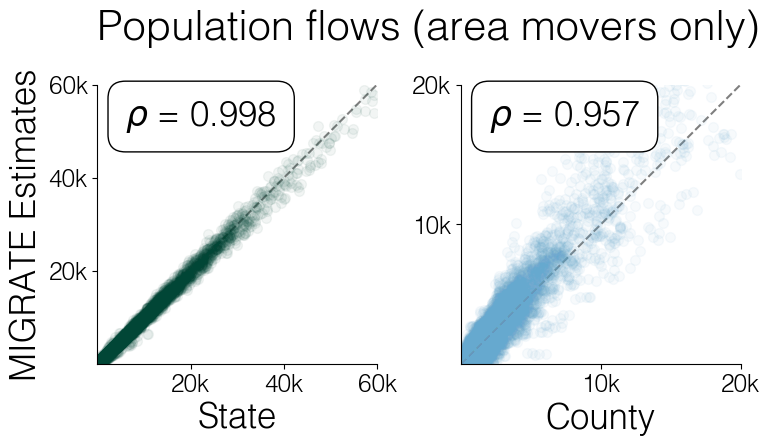

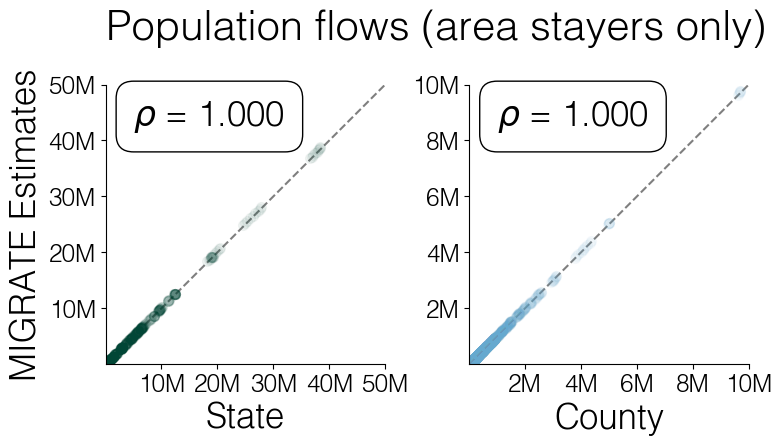

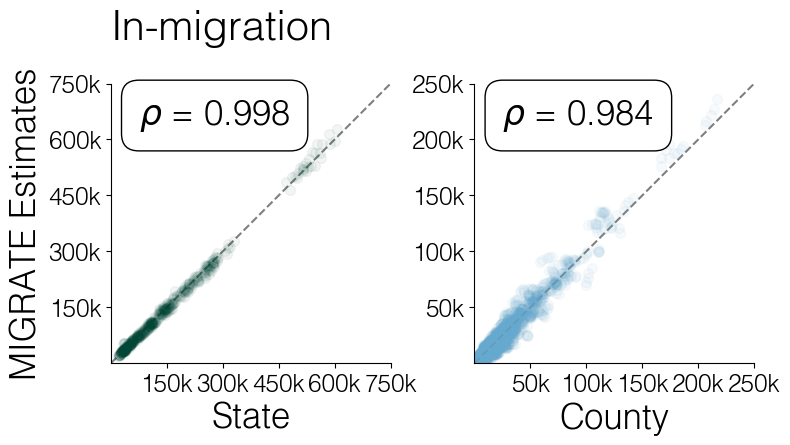

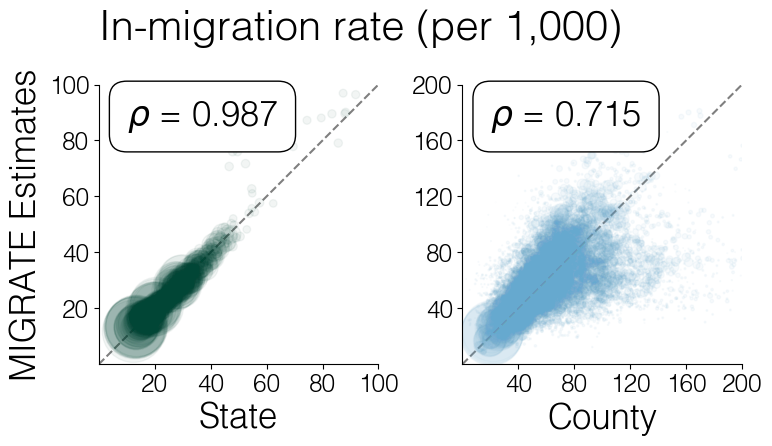

In [20]:
size, spacing = 4, .3
for quantity in ['population', 'flows', 'movers', 'stayers', 'in-migration', 'in-migration_rate']:
    quantity_array_df = all_validations_array[quantity]
    n_plots = len(quantity_array_df)
    fig, Axes = plt.subplots(figsize=((size+spacing)*n_plots - spacing, size), ncols=n_plots, gridspec_kw={'wspace': spacing})
    #Go over each data source:
    for idx, (data_descriptor, df) in enumerate(quantity_array_df.items()):
        #Get label:
        label_str = data_descriptor[1]
        if data_descriptor[0] == 'IRS': label_str += ' (IRS)'
        
        #Get the color:
        c = plot_params[quantity]['cmap']((1+idx)/n_plots)
        
        #Get values
        clean_df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=['Estimate', 'Data', 'Weight'], how='any')
        x = clean_df['Data'].values
        y = clean_df['Estimate'].values
        w = clean_df['Weight'].values
        if 'rate' in quantity: x, y = 1_000*x, 1_000*y

        #Get unit:
        if data_descriptor[1] in ['Block Group', 'Tract'] or quantity in ['in-migration', 'movers']:
            unit = 1_000
        elif 'rate' in quantity:
            unit = None
        else:
            unit = 1_000_000

        #Plot:
        ax = Axes[n_plots-idx-1]
        ax = viz.plot_correlation(x, y, w=w if 'rate' in quantity else None,
                                  title=False if data_descriptor[1] != 'State' else plot_params[quantity].get('title',False), title_fontsize=30,
                                  y_label=None, x_label=label_str,
                                  ax=ax, colors=c,
                                  markersize=plot_params[quantity].get('size_scaler', 50)*(w/max(w) if 'rate' in quantity else 1),
                                  markeralpha=.05,#0.1 if (data_descriptor[1] == 'State' and 'migration' not in quantity) else 0.05,
                                  report_corr=True, textsize=25,
                                  ticksize=17.5,
                                  negative_x=True if quantity=='net-migration' else False,
                                  rate='rate' in quantity,
                                  unit=unit,
                                  max_value=max_values.get((quantity,data_descriptor[1]), None),
                                  legend=False)
    #Label:
    _ = Axes[0].set_ylabel('MIGRATE Estimates', fontsize=25)
    plt.savefig(f'{plots_dir}validations-correlation-{quantity}.png', dpi=300, bbox_inches='tight')
    plt.savefig(f'{plots_dir}validations-correlation-{quantity}.pdf', dpi=300, bbox_inches='tight')
    plt.show()

## 3. Demographic Biases (Figure 3)

Now we will focus on documenting biases in Infutor and in our estimates. We will need to collect demographics:

In [21]:
#Collect population inferred (remember to scale Infutor):
POP_inferred = {'MIGRATE': {y-1: np.array(M.sum(axis=1)).flatten() for y,M in M_dict.items()},
                'Infutor': {y-1: (M_dict[y].sum()/E.sum())*np.array(E.sum(axis=1)).flatten() for y,E in E_dict.items()}}
POP_inferred_avg = {dataset: pd.DataFrame(p).T.rolling(window=5, min_periods=1).mean().T.to_dict(orient='list')
                    for dataset,p in POP_inferred.items()} #5-year averages for ACS comparisons
for dataset, p in POP_inferred.items(): POP_inferred_avg[dataset][2019] = list(np.mean(pd.DataFrame(p).loc[:,2015:], axis=1).values)

#Collect the fraction of geography population that belongs to each demographics:
ACS_CBG_demo = prc.get_demographics(geography='BLOCKGROUP', ignore_PR=True, years=[y for y in range(2010,2020)])
ACS_CBG_demo_pct = prc.get_demographics(geography='BLOCKGROUP', ignore_PR=True, years=[y for y in range(2010,2020)], pct=True)
ACS_COUNTY_demo_pct = prc.get_demographics(geography='COUNTY',  ignore_PR=True, years=[y for y in range(2010,2020)], pct=True)

### Population bias

We begin by examining the geography of population biases.

In [22]:
C = C_dict[('blockgroup', 'county')]
COUNTY_error = {dataset: {y: 100*((C.T @ p)/PEP_COUNTY[y]-1) for y,p in yearly_population.items()} for dataset, yearly_population in POP_inferred.items()}
COUNTY_error_mean = {dataset: pd.DataFrame(yearly_errors).mean(axis=1).values for dataset,yearly_errors in COUNTY_error.items()}

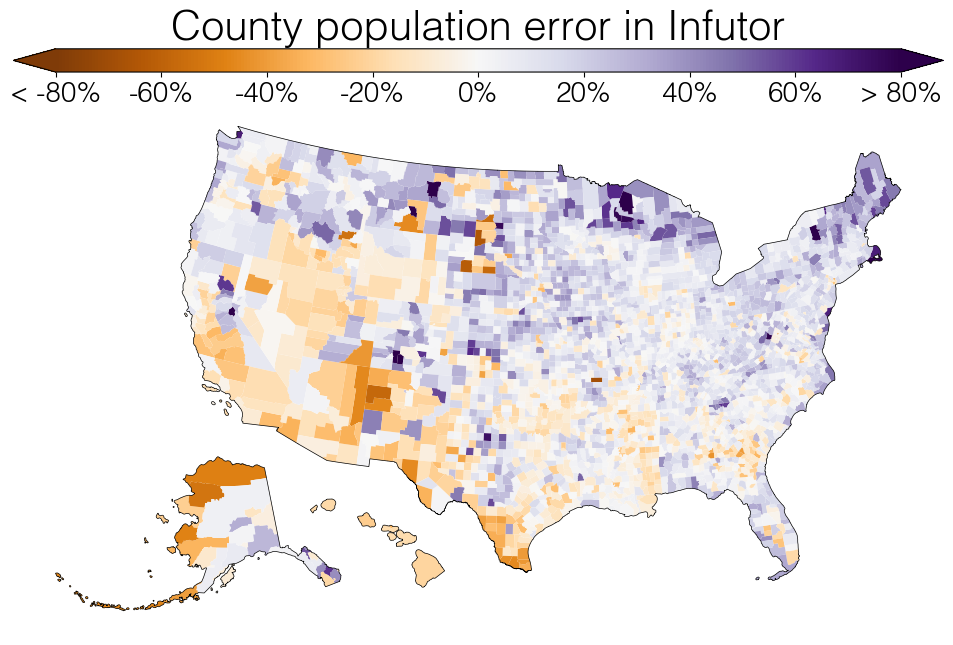

In [23]:
fig, ax = plt.subplots(figsize=(12,8))
ax = viz.map_county_population_error(COUNTY_error_mean, county_idx=county_idx, ax=ax, plot_inset=False, title=False)
plt.savefig(f'{plots_dir}biases-countypop.png', dpi=300, bbox_inches='tight')
plt.savefig(f'{plots_dir}biases-countypop.pdf', dpi=300, bbox_inches='tight')

### County-level demographic biases

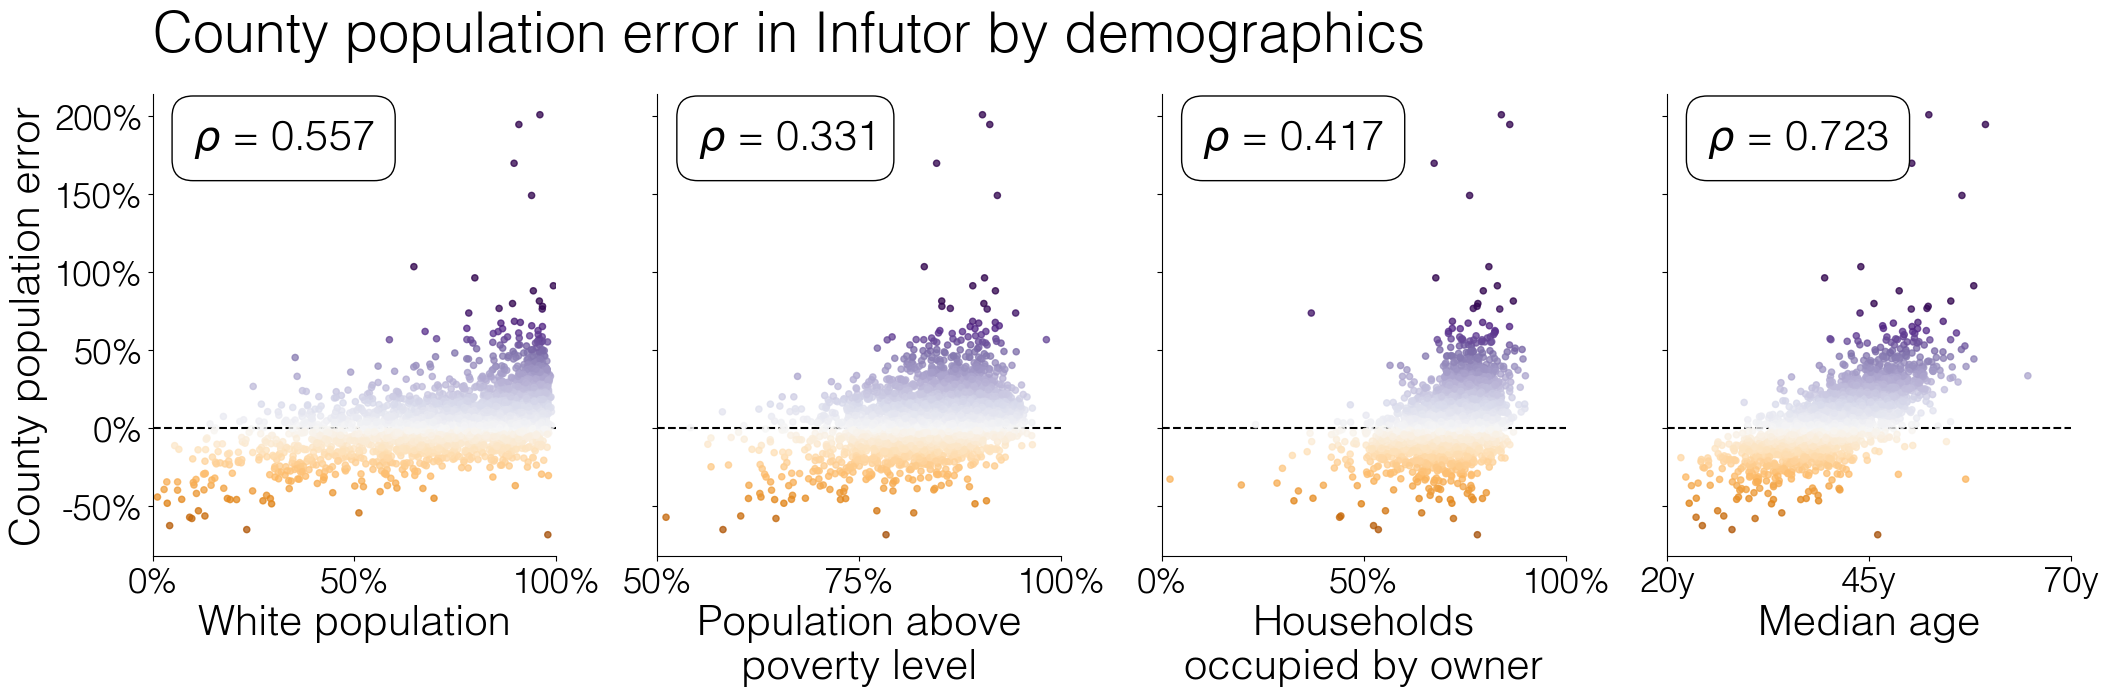

In [24]:
demographics_to_plot = [('Race', 'White'),
                        ('Poverty Level (Binary)', 'Above'),
                        ('Household Tenure', 'Owner occupied'),
                        ('Age', 'Median age')]
ACS_COUNTY_demo_mean = pd.concat([df[demographics_to_plot] for year, df in ACS_COUNTY_demo_pct.items()]).groupby(level=0).mean()

Axes = viz.plot_county_population_error(x_values=ACS_COUNTY_demo_mean.values, y_values=COUNTY_error_mean['Infutor'],
                                        y_label='County population error',
                                        x_labels=['White population', 'Population above\npoverty level', 'Households\noccupied by owner', 'Median age'],
                                        x_lims=[(0,1), (.5, 1), (0,1), (20,70)],
                                        x_ticks=[(0,  .5, 1.),
                                                 (.5, .75, 1.),
                                                 (0, .5, 1.),
                                                 (20,  45, 70)],
                                        spacing=.25, corr_type='spearman',
                                        textsize=30, ticksize=25)
_ = Axes[0].set_title('County population error in Infutor by demographics',
                      x=0, y=1.05, va='bottom', ha='left', fontsize=40)

plt.savefig(f'{plots_dir}biases-countypop-scatter.png', dpi=300, bbox_inches='tight')
plt.savefig(f'{plots_dir}biases-countypop-scatter.pdf', dpi=300, bbox_inches='tight')

### CBG-level demographic biases

In [25]:
demographics_to_plot = ['Urbanization', 'Age (Coarse)', 'Poverty Level (Binary)', 'Race',  'Household Tenure']

#Compute the population of each of these demographic groups inferred every ACS year:
POP_inferred_demo = {dataset:{ACS_year: pct_df[demographics_to_plot].multiply(np.array(avg_pop_df[ACS_year]),axis=0)
                              for ACS_year,pct_df in ACS_CBG_demo_pct.items()}
                     for dataset, avg_pop_df in POP_inferred_avg.items()}

#Sum over all CBGs:
POP_inferred_demo_totals = {dataset:{ACS_year: df.sum(axis=0)
                                     for ACS_year, df in dataset_dict.items()}
                            for dataset,dataset_dict in POP_inferred_demo.items()}

#Compare to the ACS population---reweight households and poverty-line population:
denominator = {ACS_year: pct_df[demographics_to_plot].multiply(ACS_CBG_demo[ACS_year][('Total', 'Population')].values,axis=0)
               for ACS_year, pct_df in ACS_CBG_demo_pct.items()}
POP_inferred_demo_errors = {dataset:{ACS_year: df/denominator[ACS_year].sum(axis=0) - 1
                                     for ACS_year, df in dataset_dict.items()}
                            for dataset,dataset_dict in POP_inferred_demo_totals.items()}

#Compute means and sds:
errors_est = {dataset: pd.concat(yearly_errors.values(), axis=1).mean(axis=1) for dataset, yearly_errors in POP_inferred_demo_errors.items()}
errors_std = {dataset: pd.concat(yearly_errors.values(), axis=1).std(axis=1) for dataset, yearly_errors in POP_inferred_demo_errors.items()}
display(100*pd.DataFrame(errors_est))

MIGRATE    Infutor
Urbanization           Urban              0.645453  -1.334707
                       Rural             -0.799182   7.526336
Age (Coarse)           Under 18 years     0.127627  -3.505964
                       18 to 24 years     0.412104 -10.577206
                       25 to 44 years     0.694253  -2.517351
                       45 to 64 years     0.333537   5.054715
                       65 years and over  0.381240  11.444459
Poverty Level (Binary) Below              0.572063 -11.424719
                       Above              0.318627   2.214888
Race                   White              0.293456   7.848215
                       Black              0.839771  -6.639886
                       Asian              0.904678  -6.420314
                       Hispanic           0.231703 -18.643019
Household Tenure       Owner occupied    -0.074577   4.807663
                       Renter occupied    1.170912  -8.652096

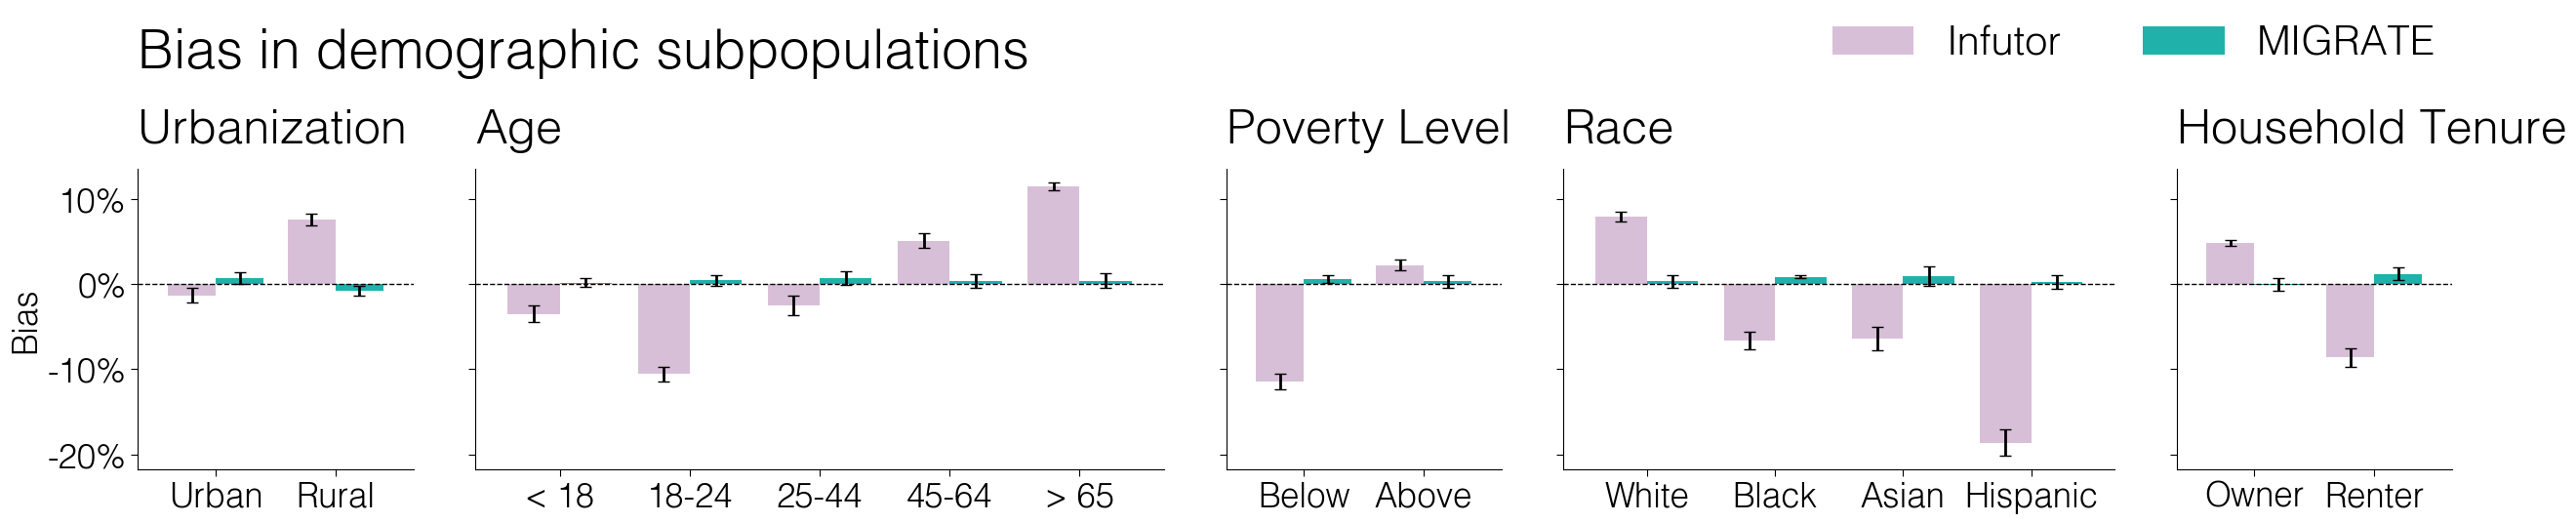

In [26]:
Axes = viz.plot_CBG_population_error(est_df=pd.DataFrame(errors_est),
                                     std_df=pd.DataFrame(errors_std),
                                     demographics_to_plot=demographics_to_plot,
                                     y_label='Bias',
                                     title_fontsize=35, textsize=25
                                    )
_ = Axes[-1].legend(bbox_to_anchor=(1., 1.3,), loc='lower right', fontsize=30, borderaxespad=0, ncols=2, frameon=False)
_ = Axes[0].text(s='Bias in demographic subpopulations', x=0, y=1.3, transform=Axes[0].transAxes, va='bottom', ha='left', fontsize=40)
plt.savefig(f'{plots_dir}biases-CBGpop.png', dpi=300, bbox_inches='tight')
plt.savefig(f'{plots_dir}biases-CBGpop.pdf', dpi=300, bbox_inches='tight')

These biases will go in the appendix:

MIGRATE    Infutor
Sex                Male                               0.331328  -0.250202
                   Female                             0.403269   0.972924
Education (Coarse) No High school                     0.122899 -11.904922
                   High school, no Bachelor's degree  0.348362   0.295748
                   Bachelor's degree or superior      0.567592   6.275847
Children           None                               0.629508   3.423623
                   One or more                       -0.021792  -5.859363

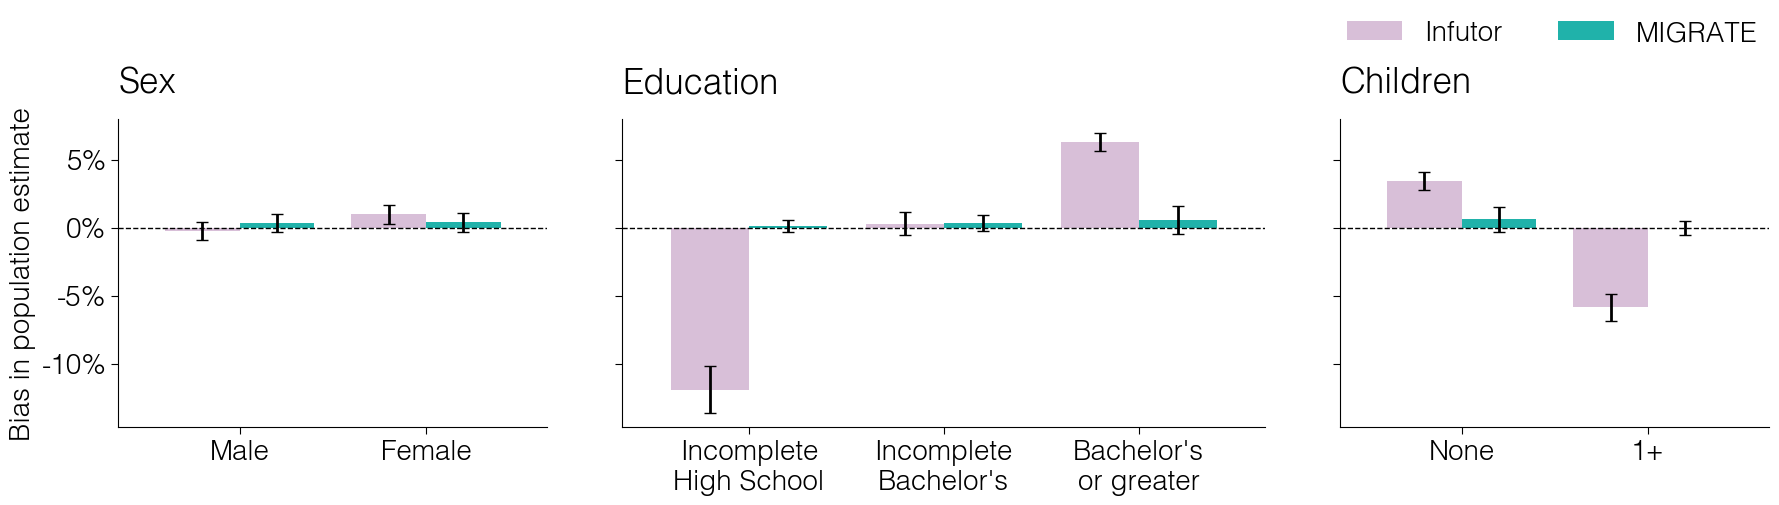

In [27]:
demographics_to_plot = ['Sex', 'Education (Coarse)', 'Children']

#Compute the population of each of these demographic groups inferred every ACS year:
POP_inferred_demo = {dataset:{ACS_year: pct_df[demographics_to_plot].multiply(np.array(avg_pop_df[ACS_year]),axis=0)
                              for ACS_year,pct_df in ACS_CBG_demo_pct.items()}
                     for dataset, avg_pop_df in POP_inferred_avg.items()}

#Sum over all CBGs:
POP_inferred_demo_totals = {dataset:{ACS_year: df.sum(axis=0)
                                     for ACS_year, df in dataset_dict.items()}
                            for dataset,dataset_dict in POP_inferred_demo.items()}

#Compare to the ACS population---reweight households and poverty-line population:
denominator = {ACS_year: pct_df[demographics_to_plot].multiply(ACS_CBG_demo[ACS_year][('Total', 'Population')].values,axis=0)
               for ACS_year, pct_df in ACS_CBG_demo_pct.items()}
POP_inferred_demo_errors = {dataset:{ACS_year: df/denominator[ACS_year].sum(axis=0) - 1
                                     for ACS_year, df in dataset_dict.items()}
                            for dataset,dataset_dict in POP_inferred_demo_totals.items()}

#Compute means and sds:
errors_est = {dataset: pd.concat(yearly_errors.values(), axis=1).mean(axis=1) for dataset, yearly_errors in POP_inferred_demo_errors.items()}
errors_std = {dataset: pd.concat(yearly_errors.values(), axis=1).std(axis=1) for dataset, yearly_errors in POP_inferred_demo_errors.items()}
display(100*pd.DataFrame(errors_est))

Axes = viz.plot_CBG_population_error(est_df=pd.DataFrame(errors_est), std_df=pd.DataFrame(errors_std),
                                     demographics_to_plot=demographics_to_plot,
                                     renames = {'No High school':"Incomplete\nHigh School", "High school, no Bachelor's degree":"Incomplete\nBachelor's",
                                                "Bachelor's degree or superior":"Bachelor's\nor greater", 'One or more':'1+'},
                                     base_width=3)
_ = Axes[-1].legend(bbox_to_anchor=(1., 1.2,), loc='lower right', fontsize=20, borderaxespad=0, ncols=2, frameon=False)
plt.savefig(f'{plots_dir}biases-CBGpop-SI.png', dpi=300, bbox_inches='tight')
plt.savefig(f'{plots_dir}biases-CBGpop-SI.pdf', dpi=300, bbox_inches='tight')